# Investigate Sky Subtraction quality
In the frame of the Sky Sprint December 10-12, 2024 https://sdss-wiki.atlassian.net/wiki/spaces/LVM/pages/14458473/LVM+Sky+Sprints


## Table preparation and metric plots

Based on `SFrame_summary.fits` file provided by Amy `https://data.sdss5.org/sas/sdsswork/lvm/spectro/redux/amjones/SFrame_summary.fits` create a table for Topcat experiments.

In [ ]:
import numpy as np
from astropy.table import Table, MaskedColumn, join, hstack
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

t_drp = Table.read("SFrame_summary.fits", hdu='DRP_ALL')
t_sky_stat = Table.read("SFrame_summary.fits", hdu='SKY_STATS')

# stack two columns
t = hstack([t_drp, t_sky_stat])

###############################################################################################
# calculate distance between moon and the farthest/nearest sky telescope and its label
t['farthest_sky_moon_sep'] = np.maximum(t['skye_moon_sep'], t['skyw_moon_sep'])
t['farthest_sky_moon_label'] = np.where(t['skye_moon_sep'] >= t['skyw_moon_sep'], 'E', 'W')
t['nearest_sky_moon_sep'] = np.minimum(t['skye_moon_sep'], t['skyw_moon_sep'])
t['nearest_sky_moon_label'] = np.where(t['skye_moon_sep'] < t['skyw_moon_sep'], 'E', 'W')

###############################################################################################
# calculate altitude for Sci and Sky telescopes and Moon for cross-check
lco_location = EarthLocation(lat=-29.01597 * u.deg, lon=-70.69208 * u.deg, height=2380 * u.m)
altaz_frame = AltAz(obstime=t['obstime'], location=lco_location)

coord_sci = SkyCoord(ra=t['sci_ra'], dec=t['sci_dec'], unit='deg')
coord_skye = SkyCoord(ra=t['skye_ra'], dec=t['skye_dec'], unit='deg')
coord_skyw = SkyCoord(ra=t['skyw_ra'], dec=t['skyw_dec'], unit='deg')
coord_moon = SkyCoord(ra=t['moon_ra'], dec=t['moon_dec'], unit='deg')

coord_sci_altaz = coord_sci.transform_to(altaz_frame)
coord_skye_altaz = coord_skye.transform_to(altaz_frame)
coord_skyw_altaz = coord_skyw.transform_to(altaz_frame)
coord_moon_altaz = coord_moon.transform_to(altaz_frame)

t['sci_alt'] = coord_sci_altaz.alt.deg
t['skye_alt'] = coord_skye_altaz.alt.deg
t['skyw_alt'] = coord_skyw_altaz.alt.deg
t['moon_alt2'] = coord_moon_altaz.alt.deg

###############################################################################################
# calculate distance between Science and Sky telescopes and farthest/nearest sky telescope and its label
t['sci_skye_sep'] = coord_sci.separation(coord_skye).deg
t['sci_skyw_sep'] = coord_sci.separation(coord_skyw).deg
t['nearest_sci_sky_sep'] = np.minimum(t['sci_skye_sep'], t['sci_skyw_sep'])
t['nearest_sci_sky_label'] = np.where(t['sci_skye_sep'] < t['sci_skyw_sep'], 'E', 'W')
t['nearest_sky_alt'] = np.where(t['sci_skye_sep'] < t['sci_skyw_sep'], t['skye_alt'], t['skyw_alt'])
t['farthest_sci_sky_sep'] = np.maximum(t['sci_skye_sep'], t['sci_skyw_sep'])
t['farthest_sci_sky_label'] = np.where(t['sci_skye_sep'] >= t['sci_skyw_sep'], 'E', 'W')
t['farthest_sky_alt'] = np.where(t['sci_skye_sep'] >= t['sci_skyw_sep'], t['skye_alt'], t['skyw_alt'])


# join classification of bad sky exposures
# t_bad = Table.read("bad_examples.csv")
# t = join(t, t_bad, keys='expnum', join_type='left')

# # add boolean category
# t['isBadSky'] = ~t['comment'].mask

# # Redefine column is5577bad as boolean
# t['is5577bad'] = ~t['is5577bad'].mask

# # add url for activation action in TOPCAT
# t['sky_QA_url'] = [f"https://data.sdss5.org/sas/sdsswork/lvm/spectro/redux/amjones/skyQA_plots/skyQA_{expnum}.pdf" for expnum in t['expnum']]

# # write output
t.write("SFrame_summary_skycategories.fits", format='fits', overwrite=True)

Now create some plots with Sky Subtraction metrics.

## Blue continuum vs. Moon separation

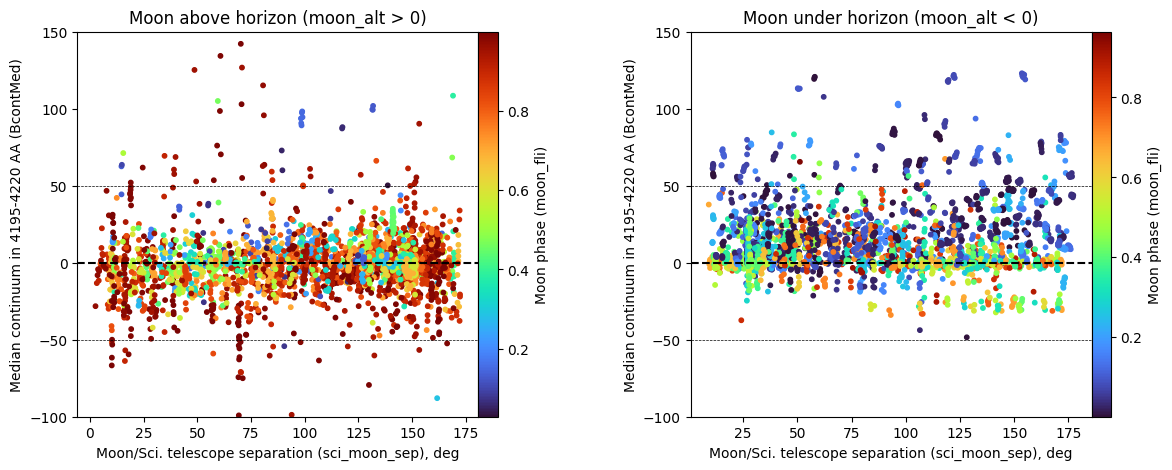

In [3]:
moon_alt_gt_0 = t[t['moon_alt'] > 0]
moon_alt_lt_0 = t[t['moon_alt'] <= 0]

fig = plt.figure(figsize=(14, 5))
gs = GridSpec(1, 2, width_ratios=[1, 1], wspace=0.3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

sc1 = ax1.scatter(moon_alt_gt_0['sci_moon_sep'], moon_alt_gt_0['BcontMed'], c=moon_alt_gt_0['moon_fli'],
                  cmap='turbo', s=10, alpha=1)

sc2 = ax2.scatter(moon_alt_lt_0['sci_moon_sep'], moon_alt_lt_0['BcontMed'], c=moon_alt_lt_0['moon_fli'],
                  cmap='turbo', s=10, alpha=1)

ax1.set_title('Moon above horizon (moon_alt > 0)')
ax2.set_title('Moon under horizon (moon_alt < 0)')

for ax, sc in zip([ax1, ax2], [sc1, sc2]):
    ax.set_ylabel('Median continuum in 4195-4220 AA (BcontMed)')
    fig.colorbar(sc, ax=ax, label='Moon phase (moon_fli)', pad=0.0)
    ax.set_xlabel('Moon/Sci. telescope separation (sci_moon_sep), deg')
    ax.set_ylim(-100, 150)
    ax.axhline(0, color='k', linestyle='--')
    ax.axhline(-50, color='k', linestyle='--', lw=0.5)
    ax.axhline(50, color='k', linestyle='--', lw=0.5)

# Sky line metrics

## OI5577 metrics vs distance between Moon and farthest Sky telescope, color-coded by Moon phase

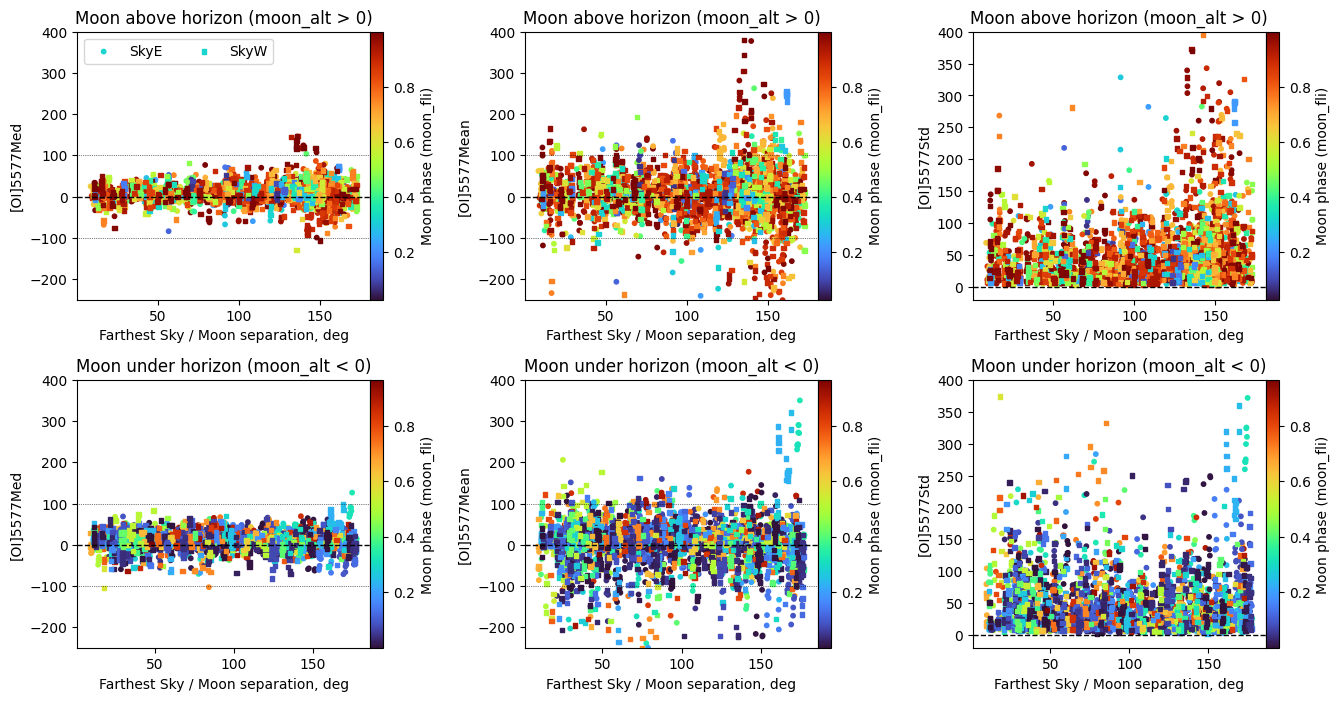

In [10]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[0, 2])

ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])
ax23 = fig.add_subplot(gs[1, 2])


for skytel, marker in zip(['E', 'W'], ['o', 's']):
    msk = (t['moon_alt'] > 0) & (t['farthest_sky_moon_label'] == skytel)
    sc11 = ax11.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OI]5577Med'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker, label=f"Sky{skytel}")
    sc12 = ax12.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OI]5577Mean'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc13 = ax13.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OI]5577Std'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)

    msk = (t['moon_alt'] <= 0) & (t['farthest_sky_moon_label'] == skytel)
    sc21 = ax21.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OI]5577Med'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc22 = ax22.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OI]5577Mean'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc23 = ax23.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OI]5577Std'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)

ax11.legend(ncols=2, loc='upper left')

ax11.set_ylabel("[OI]5577Med")
ax12.set_ylabel("[OI]5577Mean")
ax13.set_ylabel("[OI]5577Std")
ax21.set_ylabel("[OI]5577Med")
ax22.set_ylabel("[OI]5577Mean")
ax23.set_ylabel("[OI]5577Std")

for ax in ax11, ax12, ax13:
    ax.set_title('Moon above horizon (moon_alt > 0)')

for ax in ax21, ax22, ax23:
    ax.set_title('Moon under horizon (moon_alt < 0)')

for ax in ax11, ax12, ax21, ax22:
    ax.set_ylim(-250, 400)
    ax.axhline(-100, color='k', linestyle=':', lw=0.5)
    ax.axhline(100, color='k', linestyle=':', lw=0.5)

for ax in ax13, ax23:
    ax.set_ylim(-20, 400)

for ax, sc in zip([ax11, ax12, ax13, ax21, ax22, ax23], [sc11, sc12, sc13, sc21, sc22, sc23]):
    fig.colorbar(sc, ax=ax, label='Moon phase (moon_fli)', pad=0.0)
    ax.set_xlabel('Farthest Sky / Moon separation, deg')
    ax.axhline(0, color='k', linestyle='--', lw=1)

## OI5577 metrics vs distance between Sci and farthest Sky, color-coded by Science telescope altitude

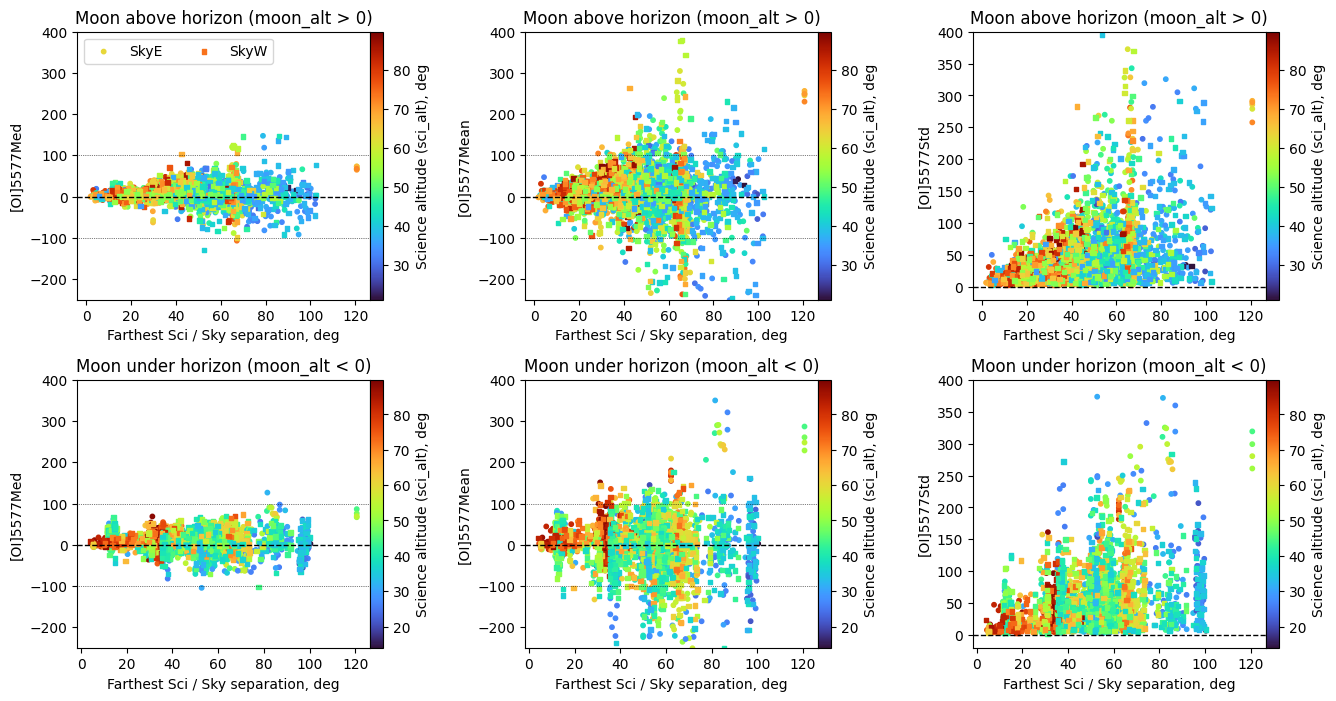

In [11]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[0, 2])

ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])
ax23 = fig.add_subplot(gs[1, 2])


for skytel, marker in zip(['E', 'W'], ['o', 's']):
    msk = (t['moon_alt'] > 0) & (t['farthest_sci_sky_label'] == skytel)
    sc11 = ax11.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]5577Med'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker, label=f"Sky{skytel}")
    sc12 = ax12.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]5577Mean'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc13 = ax13.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]5577Std'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)

    msk = (t['moon_alt'] <= 0) & (t['farthest_sci_sky_label'] == skytel)
    sc21 = ax21.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]5577Med'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc22 = ax22.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]5577Mean'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc23 = ax23.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]5577Std'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)

ax11.legend(ncols=2, loc='upper left')

ax11.set_ylabel("[OI]5577Med")
ax12.set_ylabel("[OI]5577Mean")
ax13.set_ylabel("[OI]5577Std")
ax21.set_ylabel("[OI]5577Med")
ax22.set_ylabel("[OI]5577Mean")
ax23.set_ylabel("[OI]5577Std")

for ax in ax11, ax12, ax13:
    ax.set_title('Moon above horizon (moon_alt > 0)')

for ax in ax21, ax22, ax23:
    ax.set_title('Moon under horizon (moon_alt < 0)')

for ax in ax11, ax12, ax21, ax22:
    ax.set_ylim(-250, 400)
    ax.axhline(-100, color='k', linestyle=':', lw=0.5)
    ax.axhline(100, color='k', linestyle=':', lw=0.5)

for ax in ax13, ax23:
    ax.set_ylim(-20, 400)

for ax, sc in zip([ax11, ax12, ax13, ax21, ax22, ax23], [sc11, sc12, sc13, sc21, sc22, sc23]):
    fig.colorbar(sc, ax=ax, label='Science altitude (sci_alt), deg', pad=0.0)
    ax.set_xlabel('Farthest Sci / Sky separation, deg')
    ax.axhline(0, color='k', linestyle='--', lw=1)

## OI5577 metrics vs distance between Sci and farthest Sky, color-coded by Moon phase

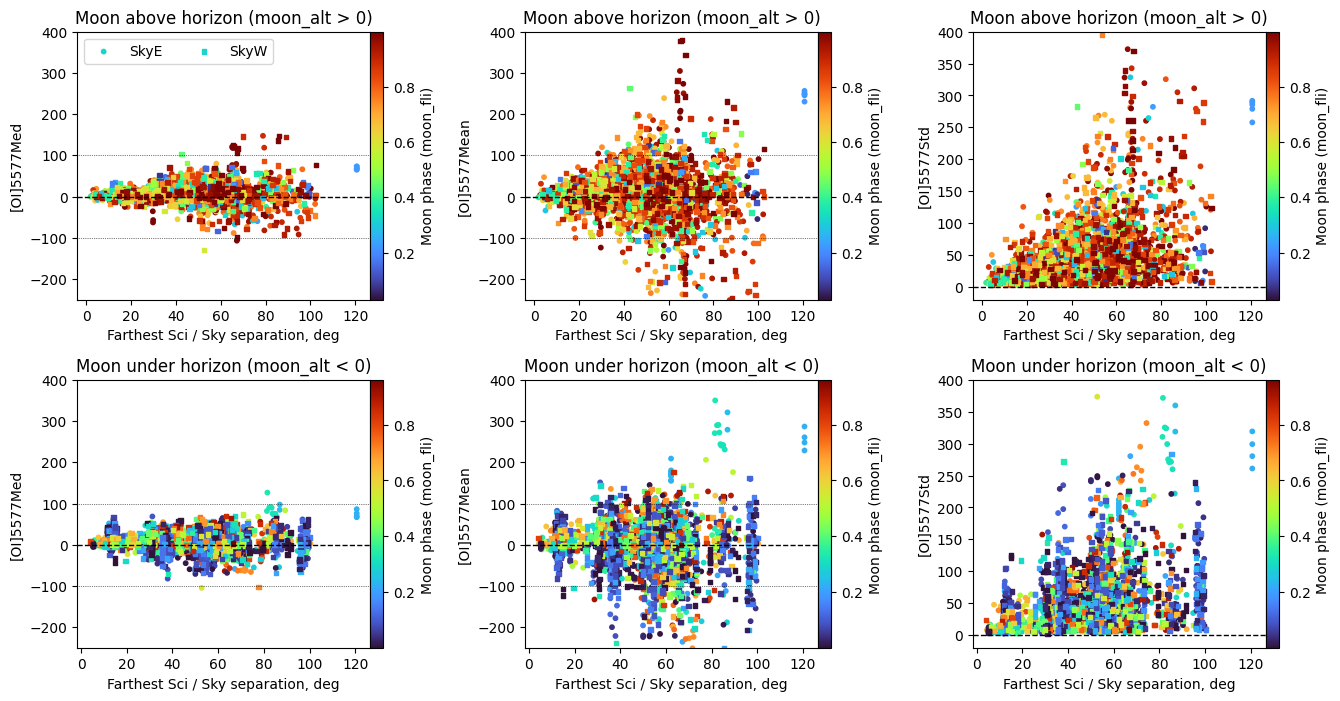

In [16]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[0, 2])

ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])
ax23 = fig.add_subplot(gs[1, 2])


for skytel, marker in zip(['E', 'W'], ['o', 's']):
    msk = (t['moon_alt'] > 0) & (t['farthest_sci_sky_label'] == skytel)
    sc11 = ax11.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]5577Med'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker, label=f"Sky{skytel}")
    sc12 = ax12.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]5577Mean'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc13 = ax13.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]5577Std'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)

    msk = (t['moon_alt'] <= 0) & (t['farthest_sci_sky_label'] == skytel)
    sc21 = ax21.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]5577Med'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc22 = ax22.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]5577Mean'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc23 = ax23.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]5577Std'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)

ax11.legend(ncols=2, loc='upper left')

ax11.set_ylabel("[OI]5577Med")
ax12.set_ylabel("[OI]5577Mean")
ax13.set_ylabel("[OI]5577Std")
ax21.set_ylabel("[OI]5577Med")
ax22.set_ylabel("[OI]5577Mean")
ax23.set_ylabel("[OI]5577Std")

for ax in ax11, ax12, ax13:
    ax.set_title('Moon above horizon (moon_alt > 0)')

for ax in ax21, ax22, ax23:
    ax.set_title('Moon under horizon (moon_alt < 0)')

for ax in ax11, ax12, ax21, ax22:
    ax.set_ylim(-250, 400)
    ax.axhline(-100, color='k', linestyle=':', lw=0.5)
    ax.axhline(100, color='k', linestyle=':', lw=0.5)

for ax in ax13, ax23:
    ax.set_ylim(-20, 400)

for ax, sc in zip([ax11, ax12, ax13, ax21, ax22, ax23], [sc11, sc12, sc13, sc21, sc22, sc23]):
    fig.colorbar(sc, ax=ax, label='Moon phase (moon_fli)', pad=0.0)
    ax.set_xlabel('Farthest Sci / Sky separation, deg')
    ax.axhline(0, color='k', linestyle='--', lw=1)

## Na I metrics vs distance between Moon and farthest Sky telescope, color-coded by Moon phase

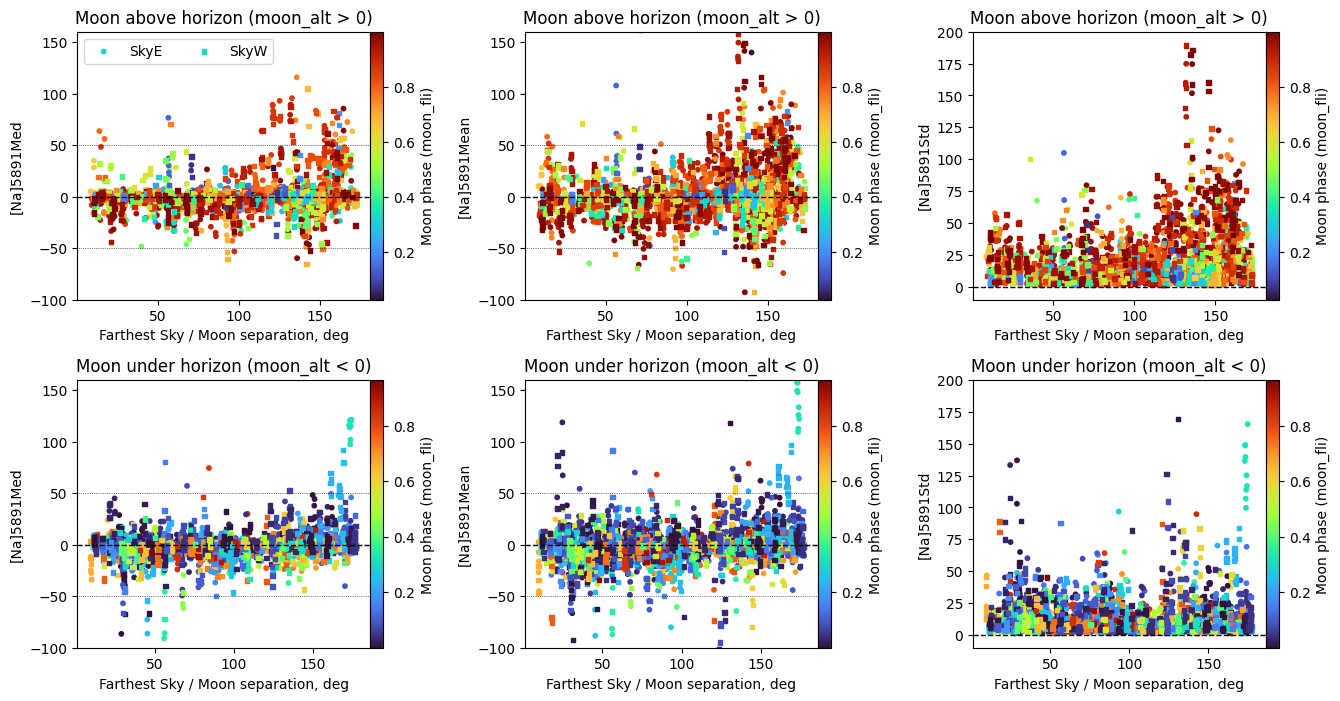

In [22]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[0, 2])

ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])
ax23 = fig.add_subplot(gs[1, 2])


for skytel, marker in zip(['E', 'W'], ['o', 's']):
    msk = (t['moon_alt'] > 0) & (t['farthest_sky_moon_label'] == skytel)
    sc11 = ax11.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[Na]5891Med'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker, label=f"Sky{skytel}")
    sc12 = ax12.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[Na]5891Mean'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc13 = ax13.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[Na]5891Std'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)

    msk = (t['moon_alt'] <= 0) & (t['farthest_sky_moon_label'] == skytel)
    sc21 = ax21.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[Na]5891Med'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc22 = ax22.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[Na]5891Mean'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc23 = ax23.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[Na]5891Std'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)

ax11.legend(ncols=2, loc='upper left')

ax11.set_ylabel("[Na]5891Med")
ax12.set_ylabel("[Na]5891Mean")
ax13.set_ylabel("[Na]5891Std")
ax21.set_ylabel("[Na]5891Med")
ax22.set_ylabel("[Na]5891Mean")
ax23.set_ylabel("[Na]5891Std")

for ax in ax11, ax12, ax13:
    ax.set_title('Moon above horizon (moon_alt > 0)')

for ax in ax21, ax22, ax23:
    ax.set_title('Moon under horizon (moon_alt < 0)')

for ax in ax11, ax12, ax21, ax22:
    ax.set_ylim(-100, 160)
    ax.axhline(-50, color='k', linestyle=':', lw=0.5)
    ax.axhline(50, color='k', linestyle=':', lw=0.5)

for ax in ax13, ax23:
    ax.set_ylim(-10, 200)

for ax, sc in zip([ax11, ax12, ax13, ax21, ax22, ax23], [sc11, sc12, sc13, sc21, sc22, sc23]):
    fig.colorbar(sc, ax=ax, label='Moon phase (moon_fli)', pad=0.0)
    ax.set_xlabel('Farthest Sky / Moon separation, deg')
    ax.axhline(0, color='k', linestyle='--', lw=1)

## Na I metrics vs distance between Sci and farthest Sky, color-coded by Science telescope altitude

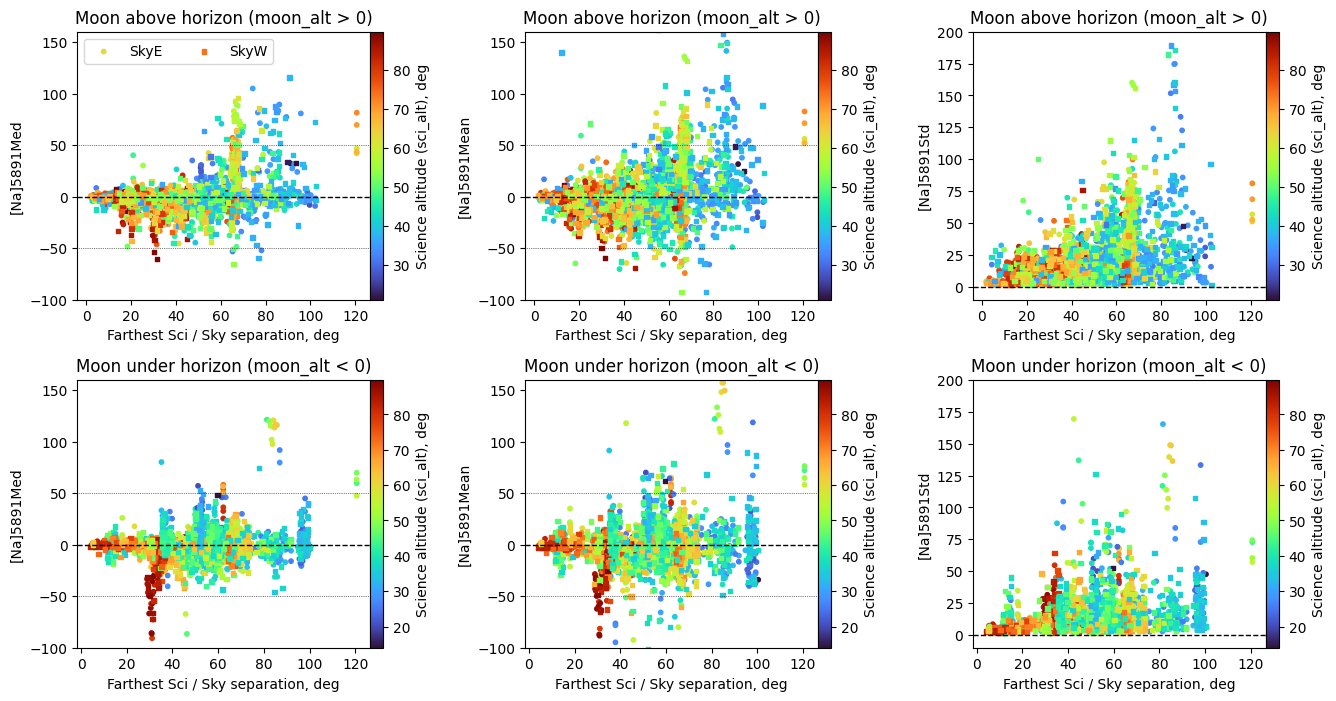

In [23]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[0, 2])

ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])
ax23 = fig.add_subplot(gs[1, 2])


for skytel, marker in zip(['E', 'W'], ['o', 's']):
    msk = (t['moon_alt'] > 0) & (t['farthest_sci_sky_label'] == skytel)
    sc11 = ax11.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[Na]5891Med'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker, label=f"Sky{skytel}")
    sc12 = ax12.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[Na]5891Mean'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc13 = ax13.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[Na]5891Std'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)

    msk = (t['moon_alt'] <= 0) & (t['farthest_sci_sky_label'] == skytel)
    sc21 = ax21.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[Na]5891Med'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc22 = ax22.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[Na]5891Mean'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc23 = ax23.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[Na]5891Std'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)

ax11.legend(ncols=2, loc='upper left')

ax11.set_ylabel("[Na]5891Med")
ax12.set_ylabel("[Na]5891Mean")
ax13.set_ylabel("[Na]5891Std")
ax21.set_ylabel("[Na]5891Med")
ax22.set_ylabel("[Na]5891Mean")
ax23.set_ylabel("[Na]5891Std")

for ax in ax11, ax12, ax13:
    ax.set_title('Moon above horizon (moon_alt > 0)')

for ax in ax21, ax22, ax23:
    ax.set_title('Moon under horizon (moon_alt < 0)')

for ax in ax11, ax12, ax21, ax22:
    ax.set_ylim(-100, 160)
    ax.axhline(-50, color='k', linestyle=':', lw=0.5)
    ax.axhline(50, color='k', linestyle=':', lw=0.5)

for ax in ax13, ax23:
    ax.set_ylim(-10, 200)

for ax, sc in zip([ax11, ax12, ax13, ax21, ax22, ax23], [sc11, sc12, sc13, sc21, sc22, sc23]):
    fig.colorbar(sc, ax=ax, label='Science altitude (sci_alt), deg', pad=0.0)
    ax.set_xlabel('Farthest Sci / Sky separation, deg')
    ax.axhline(0, color='k', linestyle='--', lw=1)

## Na I metrics vs distance between Sci and farthest Sky, color-coded by Moon phase

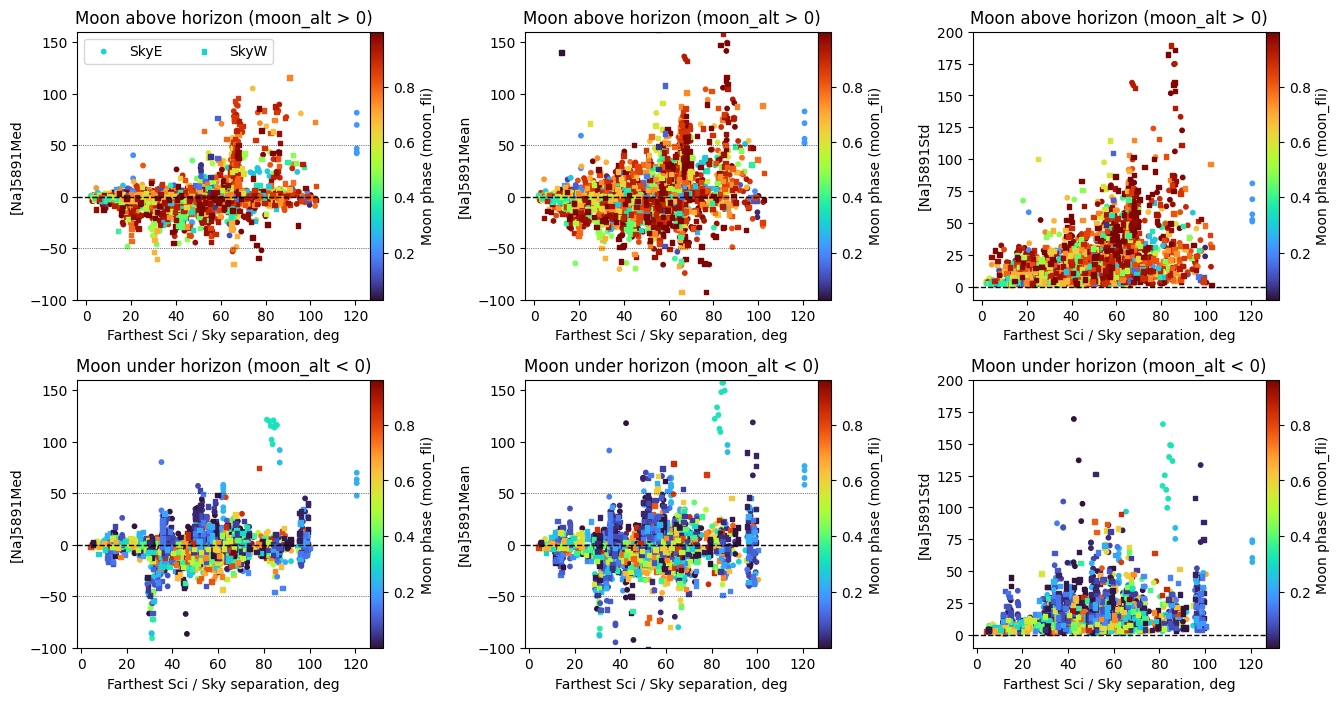

In [25]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[0, 2])

ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])
ax23 = fig.add_subplot(gs[1, 2])


for skytel, marker in zip(['E', 'W'], ['o', 's']):
    msk = (t['moon_alt'] > 0) & (t['farthest_sci_sky_label'] == skytel)
    sc11 = ax11.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[Na]5891Med'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker, label=f"Sky{skytel}")
    sc12 = ax12.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[Na]5891Mean'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc13 = ax13.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[Na]5891Std'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)

    msk = (t['moon_alt'] <= 0) & (t['farthest_sci_sky_label'] == skytel)
    sc21 = ax21.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[Na]5891Med'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc22 = ax22.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[Na]5891Mean'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc23 = ax23.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[Na]5891Std'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)

ax11.legend(ncols=2, loc='upper left')

ax11.set_ylabel("[Na]5891Med")
ax12.set_ylabel("[Na]5891Mean")
ax13.set_ylabel("[Na]5891Std")
ax21.set_ylabel("[Na]5891Med")
ax22.set_ylabel("[Na]5891Mean")
ax23.set_ylabel("[Na]5891Std")

for ax in ax11, ax12, ax13:
    ax.set_title('Moon above horizon (moon_alt > 0)')

for ax in ax21, ax22, ax23:
    ax.set_title('Moon under horizon (moon_alt < 0)')

for ax in ax11, ax12, ax21, ax22:
    ax.set_ylim(-100, 160)
    ax.axhline(-50, color='k', linestyle=':', lw=0.5)
    ax.axhline(50, color='k', linestyle=':', lw=0.5)

for ax in ax13, ax23:
    ax.set_ylim(-10, 200)

for ax, sc in zip([ax11, ax12, ax13, ax21, ax22, ax23], [sc11, sc12, sc13, sc21, sc22, sc23]):
    fig.colorbar(sc, ax=ax, label='Moon phase (moon_fli)', pad=0.0)
    ax.set_xlabel('Farthest Sci / Sky separation, deg')
    ax.axhline(0, color='k', linestyle='--', lw=1)

## [OI]6300 metrics vs distance between Moon and farthest Sky telescope, color-coded by Moon phase

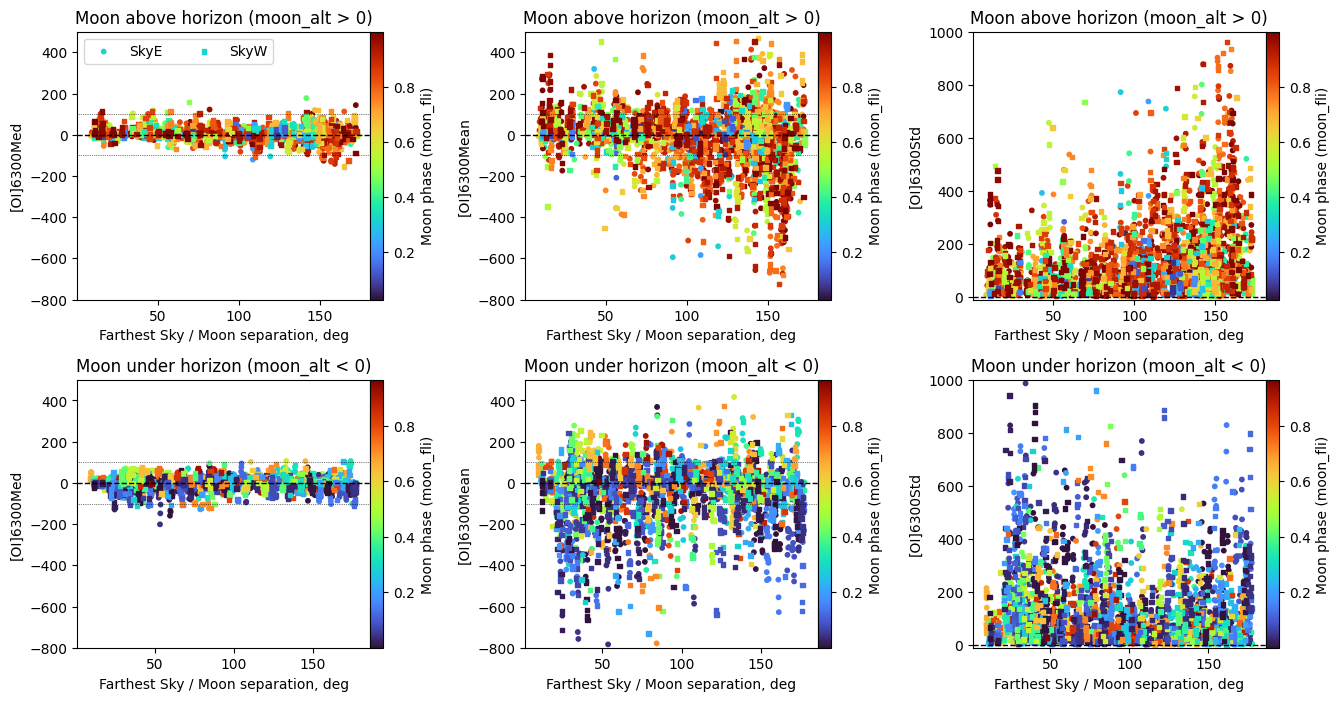

In [48]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[0, 2])

ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])
ax23 = fig.add_subplot(gs[1, 2])


for skytel, marker in zip(['E', 'W'], ['o', 's']):
    msk = (t['moon_alt'] > 0) & (t['farthest_sky_moon_label'] == skytel)
    sc11 = ax11.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OI]6300Med'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker, label=f"Sky{skytel}")
    sc12 = ax12.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OI]6300Mean'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc13 = ax13.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OI]6300Std'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)

    msk = (t['moon_alt'] <= 0) & (t['farthest_sky_moon_label'] == skytel)
    sc21 = ax21.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OI]6300Med'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc22 = ax22.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OI]6300Mean'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc23 = ax23.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OI]6300Std'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)

ax11.legend(ncols=2, loc='upper left')

ax11.set_ylabel("[OI]6300Med")
ax12.set_ylabel("[OI]6300Mean")
ax13.set_ylabel("[OI]6300Std")
ax21.set_ylabel("[OI]6300Med")
ax22.set_ylabel("[OI]6300Mean")
ax23.set_ylabel("[OI]6300Std")

for ax in ax11, ax12, ax13:
    ax.set_title('Moon above horizon (moon_alt > 0)')

for ax in ax21, ax22, ax23:
    ax.set_title('Moon under horizon (moon_alt < 0)')

for ax in ax11, ax12, ax21, ax22:
    ax.set_ylim(-800, 500)
    ax.axhline(-100, color='k', linestyle=':', lw=0.5)
    ax.axhline(100, color='k', linestyle=':', lw=0.5)

for ax in ax13, ax23:
    ax.set_ylim(-10, 1000)

for ax, sc in zip([ax11, ax12, ax13, ax21, ax22, ax23], [sc11, sc12, sc13, sc21, sc22, sc23]):
    fig.colorbar(sc, ax=ax, label='Moon phase (moon_fli)', pad=0.0)
    ax.set_xlabel('Farthest Sky / Moon separation, deg')
    ax.axhline(0, color='k', linestyle='--', lw=1)

## [OI]6300 metrics vs distance between Sci and farthest Sky, color-coded by Science telescope altitude

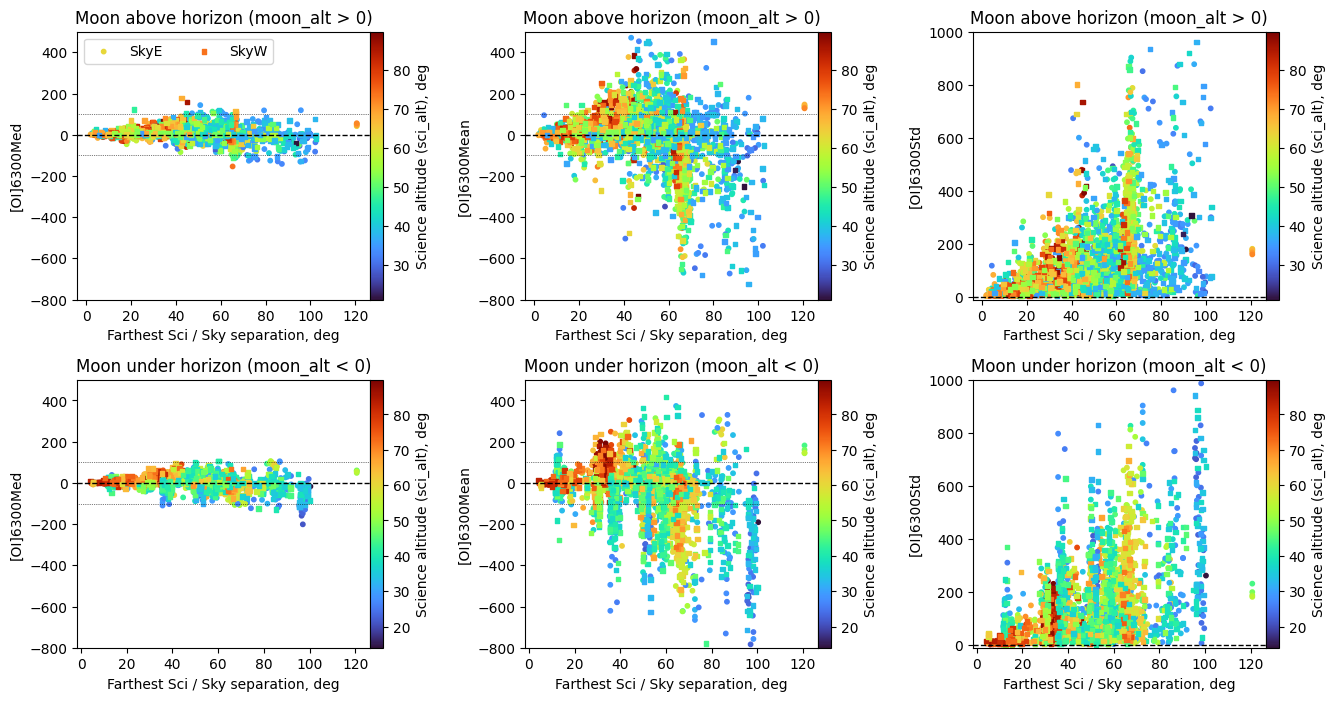

In [50]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[0, 2])

ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])
ax23 = fig.add_subplot(gs[1, 2])


for skytel, marker in zip(['E', 'W'], ['o', 's']):
    msk = (t['moon_alt'] > 0) & (t['farthest_sci_sky_label'] == skytel)
    sc11 = ax11.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]6300Med'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker, label=f"Sky{skytel}")
    sc12 = ax12.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]6300Mean'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc13 = ax13.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]6300Std'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)

    msk = (t['moon_alt'] <= 0) & (t['farthest_sci_sky_label'] == skytel)
    sc21 = ax21.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]6300Med'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc22 = ax22.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]6300Mean'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc23 = ax23.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]6300Std'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)

ax11.legend(ncols=2, loc='upper left')

ax11.set_ylabel("[OI]6300Med")
ax12.set_ylabel("[OI]6300Mean")
ax13.set_ylabel("[OI]6300Std")
ax21.set_ylabel("[OI]6300Med")
ax22.set_ylabel("[OI]6300Mean")
ax23.set_ylabel("[OI]6300Std")

for ax in ax11, ax12, ax13:
    ax.set_title('Moon above horizon (moon_alt > 0)')

for ax in ax21, ax22, ax23:
    ax.set_title('Moon under horizon (moon_alt < 0)')

for ax in ax11, ax12, ax21, ax22:
    ax.set_ylim(-800, 500)
    ax.axhline(-100, color='k', linestyle=':', lw=0.5)
    ax.axhline(100, color='k', linestyle=':', lw=0.5)

for ax in ax13, ax23:
    ax.set_ylim(-10, 1000)

for ax, sc in zip([ax11, ax12, ax13, ax21, ax22, ax23], [sc11, sc12, sc13, sc21, sc22, sc23]):
    fig.colorbar(sc, ax=ax, label='Science altitude (sci_alt), deg', pad=0.0)
    ax.set_xlabel('Farthest Sci / Sky separation, deg')
    ax.axhline(0, color='k', linestyle='--', lw=1)

## [OI]6300 metrics vs distance between Sci and farthest Sky, color-coded by Moon phase

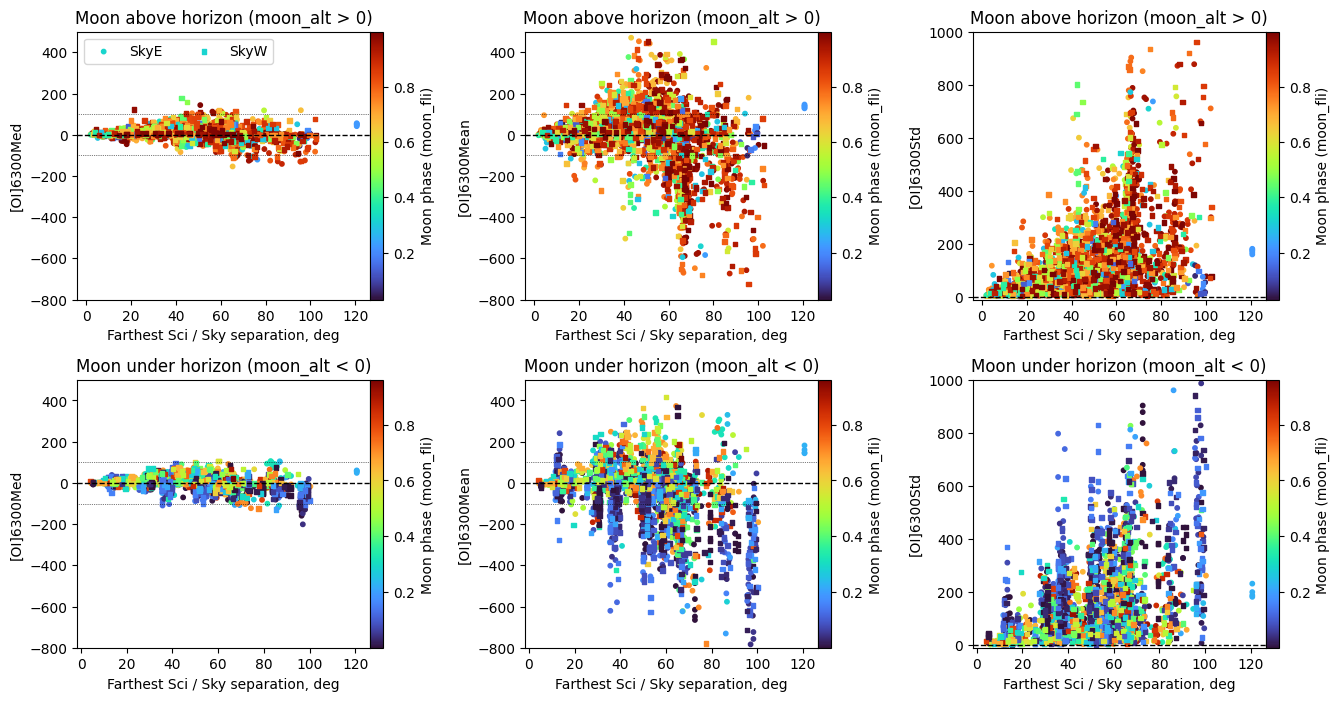

In [52]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[0, 2])

ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])
ax23 = fig.add_subplot(gs[1, 2])


for skytel, marker in zip(['E', 'W'], ['o', 's']):
    msk = (t['moon_alt'] > 0) & (t['farthest_sci_sky_label'] == skytel)
    sc11 = ax11.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]6300Med'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker, label=f"Sky{skytel}")
    sc12 = ax12.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]6300Mean'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc13 = ax13.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]6300Std'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)

    msk = (t['moon_alt'] <= 0) & (t['farthest_sci_sky_label'] == skytel)
    sc21 = ax21.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]6300Med'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc22 = ax22.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]6300Mean'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc23 = ax23.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OI]6300Std'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)

ax11.legend(ncols=2, loc='upper left')

ax11.set_ylabel("[OI]6300Med")
ax12.set_ylabel("[OI]6300Mean")
ax13.set_ylabel("[OI]6300Std")
ax21.set_ylabel("[OI]6300Med")
ax22.set_ylabel("[OI]6300Mean")
ax23.set_ylabel("[OI]6300Std")

for ax in ax11, ax12, ax13:
    ax.set_title('Moon above horizon (moon_alt > 0)')

for ax in ax21, ax22, ax23:
    ax.set_title('Moon under horizon (moon_alt < 0)')

for ax in ax11, ax12, ax21, ax22:
    ax.set_ylim(-800, 500)
    ax.axhline(-100, color='k', linestyle=':', lw=0.5)
    ax.axhline(100, color='k', linestyle=':', lw=0.5)

for ax in ax13, ax23:
    ax.set_ylim(-10, 1000)

for ax, sc in zip([ax11, ax12, ax13, ax21, ax22, ax23], [sc11, sc12, sc13, sc21, sc22, sc23]):
    fig.colorbar(sc, ax=ax, label='Moon phase (moon_fli)', pad=0.0)
    ax.set_xlabel('Farthest Sci / Sky separation, deg')
    ax.axhline(0, color='k', linestyle='--', lw=1)

## [OH]6865 metrics vs distance between Moon and farthest Sky telescope, color-coded by Moon phase

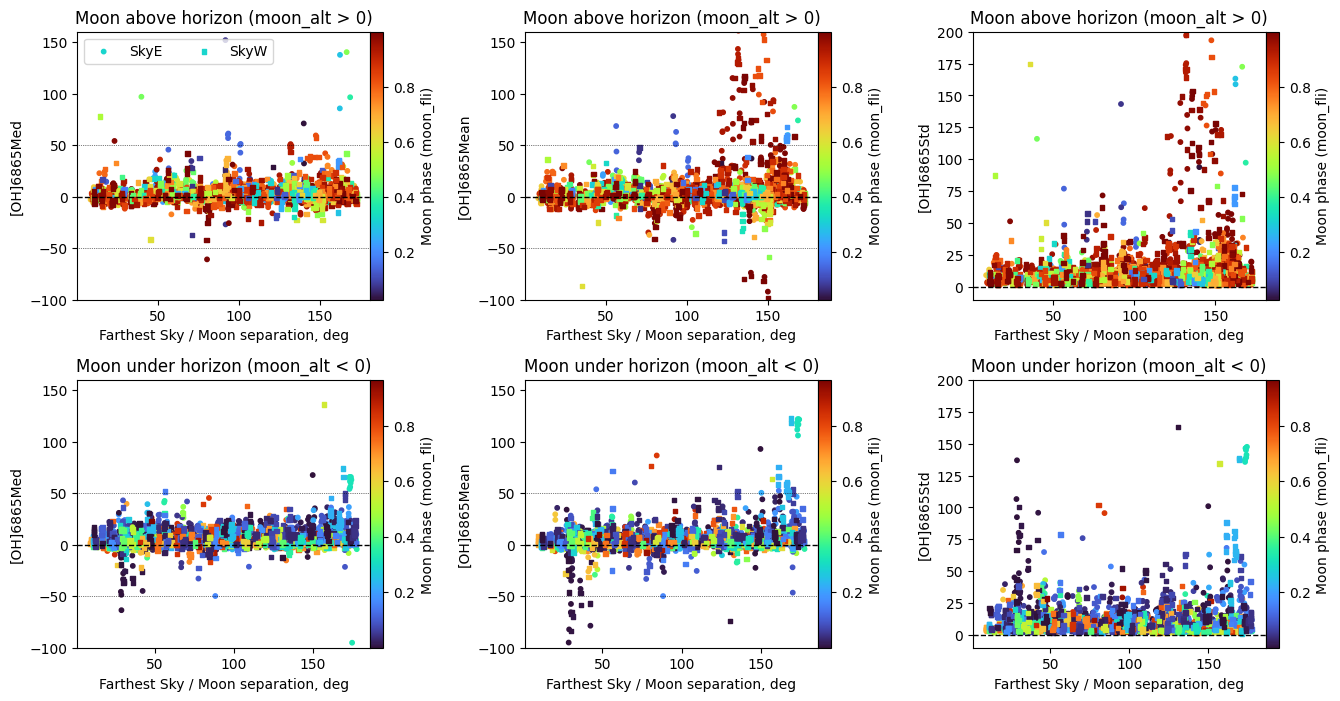

In [ ]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[0, 2])

ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])
ax23 = fig.add_subplot(gs[1, 2])


for skytel, marker in zip(['E', 'W'], ['o', 's']):
    msk = (t['moon_alt'] > 0) & (t['farthest_sky_moon_label'] == skytel)
    sc11 = ax11.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OH]6865Med'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker, label=f"Sky{skytel}")
    sc12 = ax12.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OH]6865Mean'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc13 = ax13.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OH]6865Std'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)

    msk = (t['moon_alt'] <= 0) & (t['farthest_sky_moon_label'] == skytel)
    sc21 = ax21.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OH]6865Med'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc22 = ax22.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OH]6865Mean'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc23 = ax23.scatter(t[msk]['farthest_sky_moon_sep'], t[msk]['[OH]6865Std'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)

ax11.legend(ncols=2, loc='upper left')

ax11.set_ylabel("[OH]6865Med")
ax12.set_ylabel("[OH]6865Mean")
ax13.set_ylabel("[OH]6865Std")
ax21.set_ylabel("[OH]6865Med")
ax22.set_ylabel("[OH]6865Mean")
ax23.set_ylabel("[OH]6865Std")

for ax in ax11, ax12, ax13:
    ax.set_title('Moon above horizon (moon_alt > 0)')

for ax in ax21, ax22, ax23:
    ax.set_title('Moon under horizon (moon_alt < 0)')

for ax in ax11, ax12, ax21, ax22:
    ax.set_ylim(-100, 160)
    ax.axhline(-50, color='k', linestyle=':', lw=0.5)
    ax.axhline(50, color='k', linestyle=':', lw=0.5)

for ax in ax13, ax23:
    ax.set_ylim(-10, 200)

for ax, sc in zip([ax11, ax12, ax13, ax21, ax22, ax23], [sc11, sc12, sc13, sc21, sc22, sc23]):
    fig.colorbar(sc, ax=ax, label='Moon phase (moon_fli)', pad=0.0)
    ax.set_xlabel('Farthest Sky / Moon separation, deg')
    ax.axhline(0, color='k', linestyle='--', lw=1)

## [OH]6865 metrics vs distance between Sci and farthest Sky, color-coded by Science telescope altitude

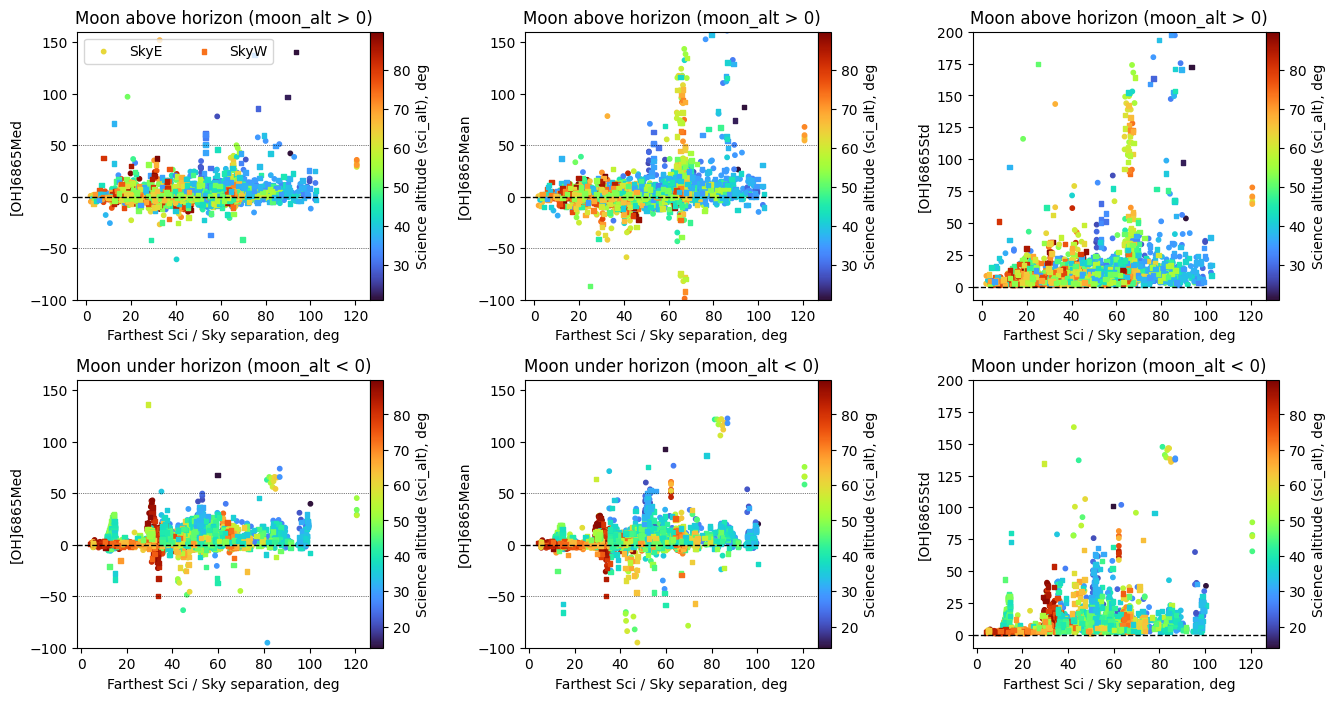

In [ ]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[0, 2])

ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])
ax23 = fig.add_subplot(gs[1, 2])


for skytel, marker in zip(['E', 'W'], ['o', 's']):
    msk = (t['moon_alt'] > 0) & (t['farthest_sci_sky_label'] == skytel)
    sc11 = ax11.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OH]6865Med'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker, label=f"Sky{skytel}")
    sc12 = ax12.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OH]6865Mean'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc13 = ax13.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OH]6865Std'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)

    msk = (t['moon_alt'] <= 0) & (t['farthest_sci_sky_label'] == skytel)
    sc21 = ax21.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OH]6865Med'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc22 = ax22.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OH]6865Mean'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc23 = ax23.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OH]6865Std'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)

ax11.legend(ncols=2, loc='upper left')

ax11.set_ylabel("[OH]6865Med")
ax12.set_ylabel("[OH]6865Mean")
ax13.set_ylabel("[OH]6865Std")
ax21.set_ylabel("[OH]6865Med")
ax22.set_ylabel("[OH]6865Mean")
ax23.set_ylabel("[OH]6865Std")

for ax in ax11, ax12, ax13:
    ax.set_title('Moon above horizon (moon_alt > 0)')

for ax in ax21, ax22, ax23:
    ax.set_title('Moon under horizon (moon_alt < 0)')

for ax in ax11, ax12, ax21, ax22:
    ax.set_ylim(-100, 160)
    ax.axhline(-50, color='k', linestyle=':', lw=0.5)
    ax.axhline(50, color='k', linestyle=':', lw=0.5)

for ax in ax13, ax23:
    ax.set_ylim(-10, 200)

for ax, sc in zip([ax11, ax12, ax13, ax21, ax22, ax23], [sc11, sc12, sc13, sc21, sc22, sc23]):
    fig.colorbar(sc, ax=ax, label='Science altitude (sci_alt), deg', pad=0.0)
    ax.set_xlabel('Farthest Sci / Sky separation, deg')
    ax.axhline(0, color='k', linestyle='--', lw=1)

## [OH]6865 metrics vs distance between Sci and farthest Sky, color-coded by Moon phase

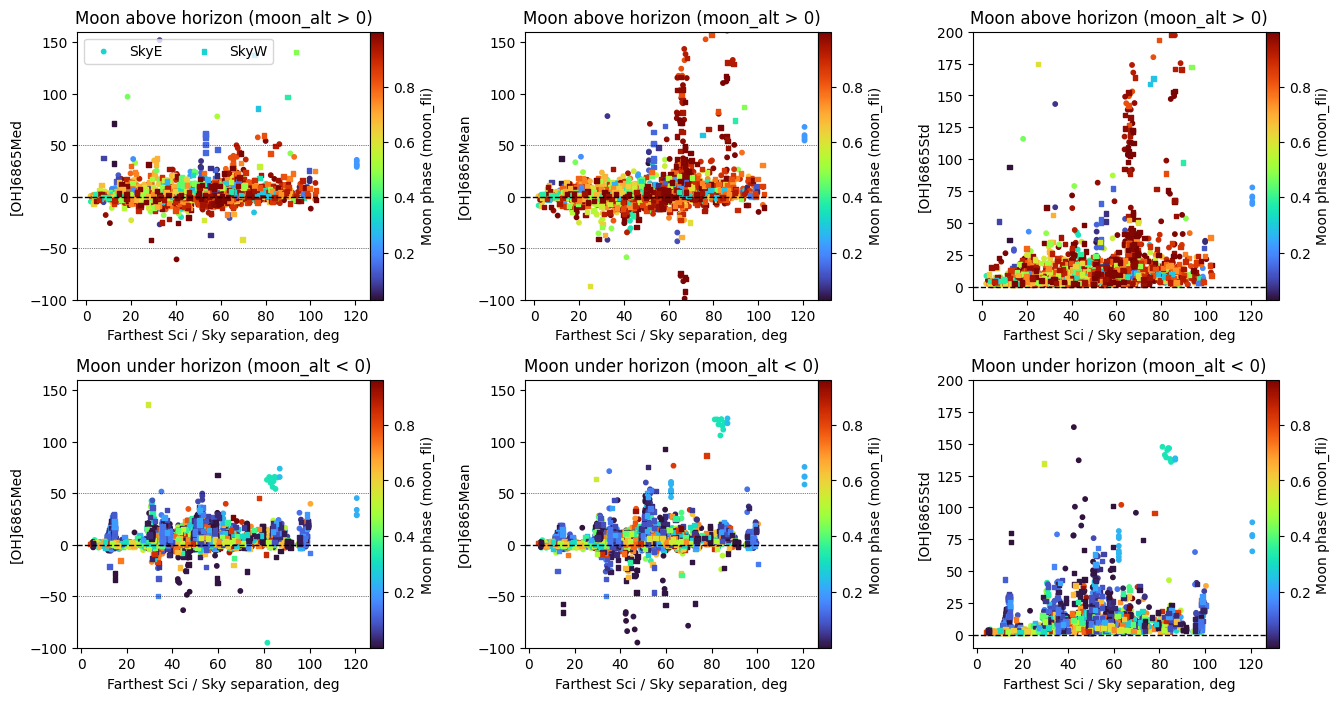

In [ ]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[0, 2])

ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])
ax23 = fig.add_subplot(gs[1, 2])


for skytel, marker in zip(['E', 'W'], ['o', 's']):
    msk = (t['moon_alt'] > 0) & (t['farthest_sci_sky_label'] == skytel)
    sc11 = ax11.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OH]6865Med'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker, label=f"Sky{skytel}")
    sc12 = ax12.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OH]6865Mean'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc13 = ax13.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OH]6865Std'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)

    msk = (t['moon_alt'] <= 0) & (t['farthest_sci_sky_label'] == skytel)
    sc21 = ax21.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OH]6865Med'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc22 = ax22.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OH]6865Mean'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc23 = ax23.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['[OH]6865Std'], c=t[msk]['moon_fli'], cmap='turbo', s=10, alpha=1, marker=marker)

ax11.legend(ncols=2, loc='upper left')

ax11.set_ylabel("[OH]6865Med")
ax12.set_ylabel("[OH]6865Mean")
ax13.set_ylabel("[OH]6865Std")
ax21.set_ylabel("[OH]6865Med")
ax22.set_ylabel("[OH]6865Mean")
ax23.set_ylabel("[OH]6865Std")

for ax in ax11, ax12, ax13:
    ax.set_title('Moon above horizon (moon_alt > 0)')

for ax in ax21, ax22, ax23:
    ax.set_title('Moon under horizon (moon_alt < 0)')

for ax in ax11, ax12, ax21, ax22:
    ax.set_ylim(-100, 160)
    ax.axhline(-50, color='k', linestyle=':', lw=0.5)
    ax.axhline(50, color='k', linestyle=':', lw=0.5)

for ax in ax13, ax23:
    ax.set_ylim(-10, 200)

for ax, sc in zip([ax11, ax12, ax13, ax21, ax22, ax23], [sc11, sc12, sc13, sc21, sc22, sc23]):
    fig.colorbar(sc, ax=ax, label='Moon phase (moon_fli)', pad=0.0)
    ax.set_xlabel('Farthest Sci / Sky separation, deg')
    ax.axhline(0, color='k', linestyle='--', lw=1)

# Continuum metrics

## Continuum metrics vs distance between Sci and nearest Sky, color-coded by Science altitude

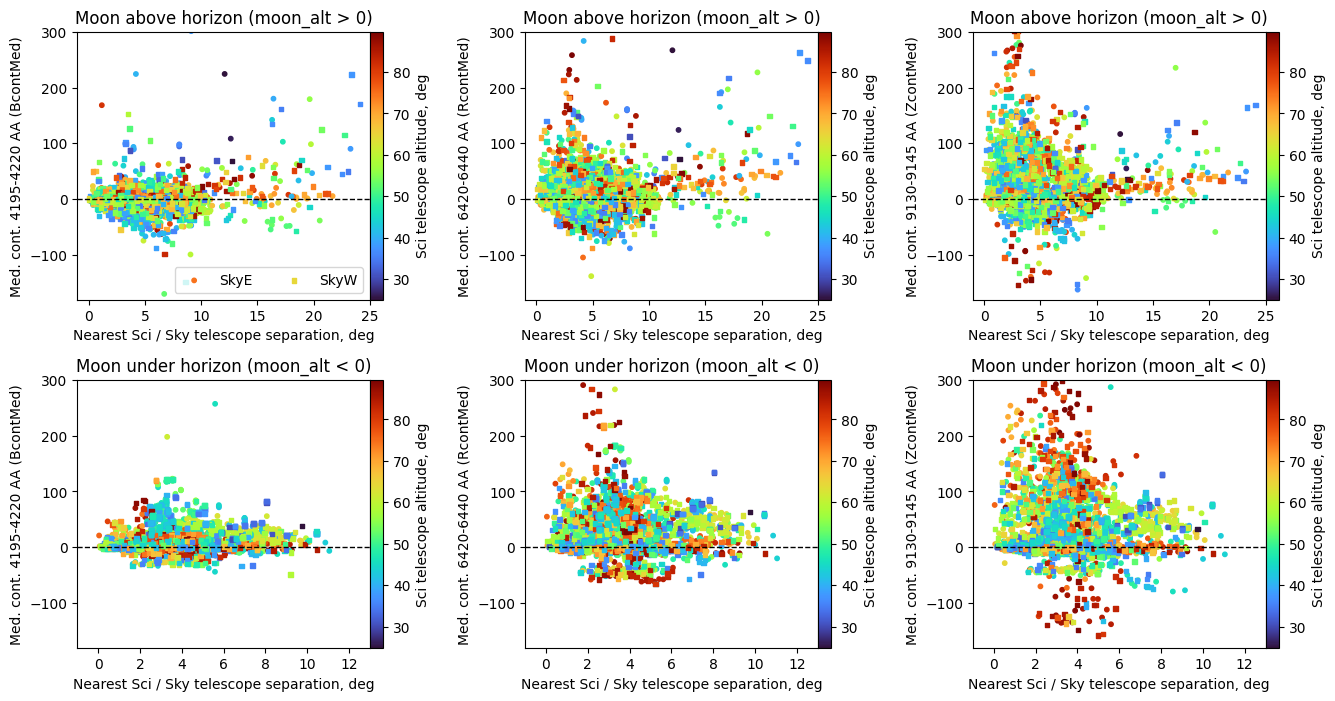

In [12]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[0, 2])

ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])
ax23 = fig.add_subplot(gs[1, 2])


for skytel, marker in zip(['E', 'W'], ['o', 's']):
    msk = (t['moon_alt'] > 0) & (t['nearest_sci_sky_label'] == skytel)
    sc11 = ax11.scatter(t[msk]['nearest_sci_sky_sep'], t[msk]['BcontMed'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker, label=f"Sky{skytel}")
    sc12 = ax12.scatter(t[msk]['nearest_sci_sky_sep'], t[msk]['RcontMed'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc13 = ax13.scatter(t[msk]['nearest_sci_sky_sep'], t[msk]['ZcontMed'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)

    msk = (t['moon_alt'] <= 0) & (t['nearest_sci_sky_label'] == skytel)
    sc21 = ax21.scatter(t[msk]['nearest_sci_sky_sep'], t[msk]['BcontMed'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc22 = ax22.scatter(t[msk]['nearest_sci_sky_sep'], t[msk]['RcontMed'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc23 = ax23.scatter(t[msk]['nearest_sci_sky_sep'], t[msk]['ZcontMed'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)

ax11.legend(ncols=2, loc='lower right')

ax11.set_ylabel('Med. cont. 4195-4220 AA (BcontMed)')
ax12.set_ylabel('Med. cont. 6420-6440 AA (RcontMed)')
ax13.set_ylabel('Med. cont. 9130-9145 AA (ZcontMed)')
ax21.set_ylabel('Med. cont. 4195-4220 AA (BcontMed)')
ax22.set_ylabel('Med. cont. 6420-6440 AA (RcontMed)')
ax23.set_ylabel('Med. cont. 9130-9145 AA (ZcontMed)')

for ax in ax11, ax12, ax13:
    ax.set_title('Moon above horizon (moon_alt > 0)')
    ax.set_xlim(-1, 25)

for ax in ax21, ax22, ax23:
    ax.set_title('Moon under horizon (moon_alt < 0)')
    ax.set_xlim(-1, 13)

for ax, sc in zip([ax11, ax12, ax13, ax21, ax22, ax23], [sc11, sc12, sc13, sc21, sc22, sc23]):
    fig.colorbar(sc, ax=ax, label='Sci telescope altitude, deg', pad=0.0)
    ax.set_xlabel('Nearest Sci / Sky telescope separation, deg')
    ax.axhline(0, color='k', linestyle='--', lw=1)
    ax.set_ylim(-180, 300)

## Continuum metrics vs distance between Sci and farthest Sky, color-coded by farthest Sky telescope altitude

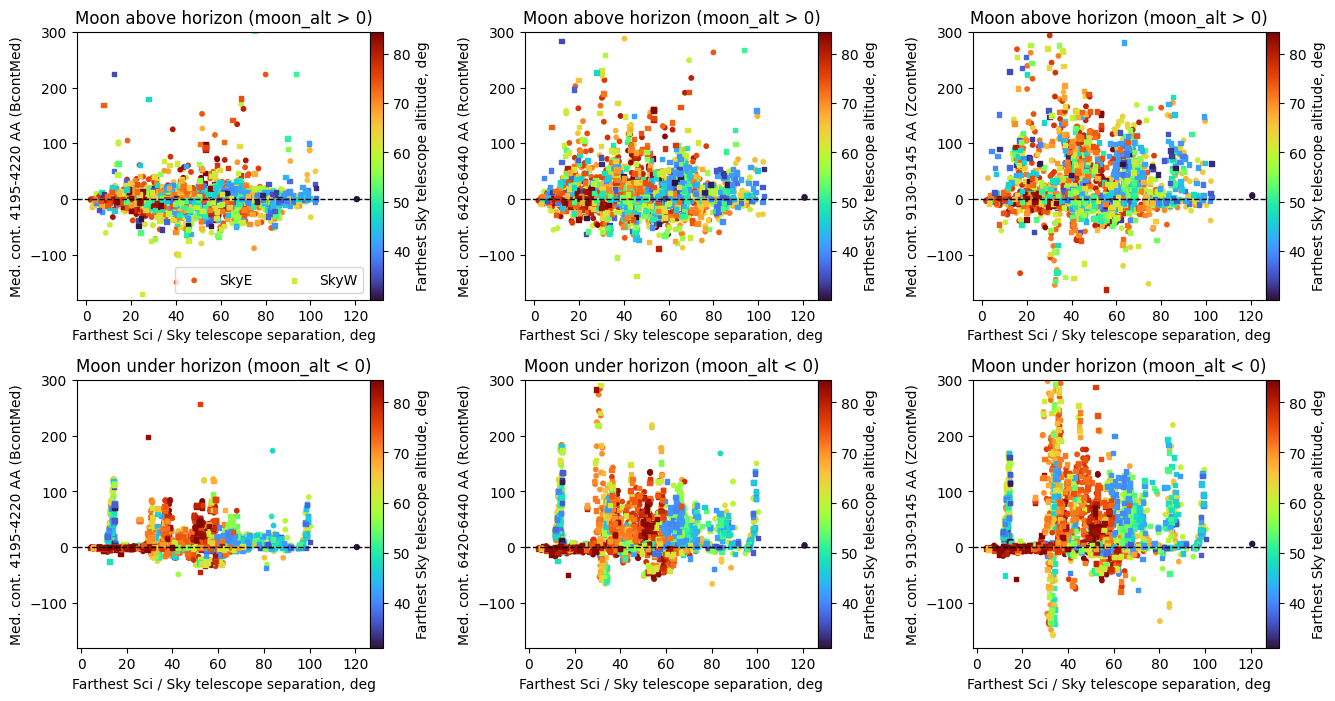

In [13]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[0, 2])

ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])
ax23 = fig.add_subplot(gs[1, 2])


for skytel, marker in zip(['E', 'W'], ['o', 's']):
    msk = (t['moon_alt'] > 0) & (t['farthest_sci_sky_label'] == skytel)
    sc11 = ax11.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['BcontMed'], c=t[msk]['farthest_sky_alt'], cmap='turbo', s=10, alpha=1, marker=marker, label=f"Sky{skytel}")
    sc12 = ax12.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['RcontMed'], c=t[msk]['farthest_sky_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc13 = ax13.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['ZcontMed'], c=t[msk]['farthest_sky_alt'], cmap='turbo', s=10, alpha=1, marker=marker)

    msk = (t['moon_alt'] <= 0) & (t['farthest_sci_sky_label'] == skytel)
    sc21 = ax21.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['BcontMed'], c=t[msk]['farthest_sky_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc22 = ax22.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['RcontMed'], c=t[msk]['farthest_sky_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc23 = ax23.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['ZcontMed'], c=t[msk]['farthest_sky_alt'], cmap='turbo', s=10, alpha=1, marker=marker)

ax11.legend(ncols=2, loc='lower right')

ax11.set_ylabel('Med. cont. 4195-4220 AA (BcontMed)')
ax12.set_ylabel('Med. cont. 6420-6440 AA (RcontMed)')
ax13.set_ylabel('Med. cont. 9130-9145 AA (ZcontMed)')
ax21.set_ylabel('Med. cont. 4195-4220 AA (BcontMed)')
ax22.set_ylabel('Med. cont. 6420-6440 AA (RcontMed)')
ax23.set_ylabel('Med. cont. 9130-9145 AA (ZcontMed)')

for ax in ax11, ax12, ax13:
    ax.set_title('Moon above horizon (moon_alt > 0)')
    # ax.set_xlim(-1, 25)

for ax in ax21, ax22, ax23:
    ax.set_title('Moon under horizon (moon_alt < 0)')
    # ax.set_xlim(-1, 13)

for ax, sc in zip([ax11, ax12, ax13, ax21, ax22, ax23], [sc11, sc12, sc13, sc21, sc22, sc23]):
    fig.colorbar(sc, ax=ax, label='Farthest Sky telescope altitude, deg', pad=0.0)
    ax.set_xlabel('Farthest Sci / Sky telescope separation, deg')
    ax.axhline(0, color='k', linestyle='--', lw=1)
    ax.set_ylim(-180, 300)

## Continuum metrics vs distance between Sci and farthest Sky, color-coded by Science telescope altitude

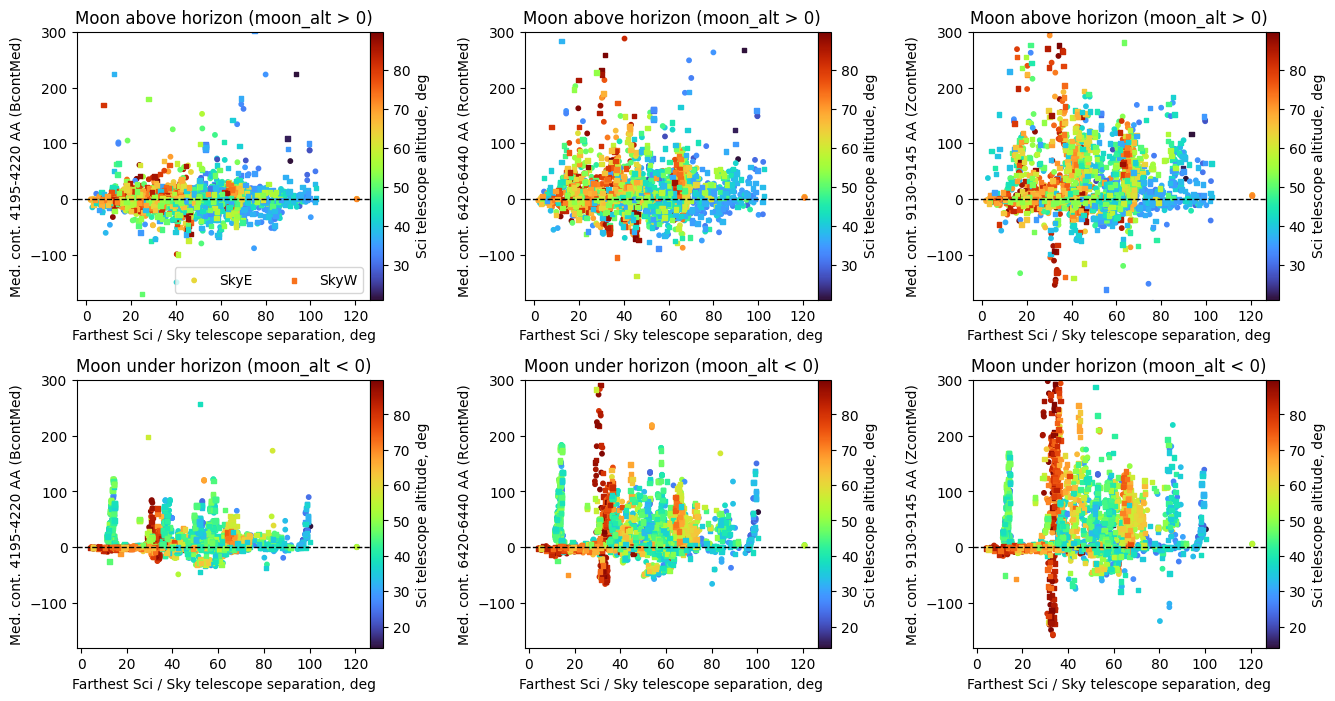

In [14]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.3, hspace=0.3)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax13 = fig.add_subplot(gs[0, 2])

ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])
ax23 = fig.add_subplot(gs[1, 2])


for skytel, marker in zip(['E', 'W'], ['o', 's']):
    msk = (t['moon_alt'] > 0) & (t['farthest_sci_sky_label'] == skytel)
    sc11 = ax11.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['BcontMed'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker, label=f"Sky{skytel}")
    sc12 = ax12.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['RcontMed'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc13 = ax13.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['ZcontMed'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)

    msk = (t['moon_alt'] <= 0) & (t['farthest_sci_sky_label'] == skytel)
    sc21 = ax21.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['BcontMed'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc22 = ax22.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['RcontMed'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)
    sc23 = ax23.scatter(t[msk]['farthest_sci_sky_sep'], t[msk]['ZcontMed'], c=t[msk]['sci_alt'], cmap='turbo', s=10, alpha=1, marker=marker)

ax11.legend(ncols=2, loc='lower right')

ax11.set_ylabel('Med. cont. 4195-4220 AA (BcontMed)')
ax12.set_ylabel('Med. cont. 6420-6440 AA (RcontMed)')
ax13.set_ylabel('Med. cont. 9130-9145 AA (ZcontMed)')
ax21.set_ylabel('Med. cont. 4195-4220 AA (BcontMed)')
ax22.set_ylabel('Med. cont. 6420-6440 AA (RcontMed)')
ax23.set_ylabel('Med. cont. 9130-9145 AA (ZcontMed)')

for ax in ax11, ax12, ax13:
    ax.set_title('Moon above horizon (moon_alt > 0)')
    # ax.set_xlim(-1, 25)

for ax in ax21, ax22, ax23:
    ax.set_title('Moon under horizon (moon_alt < 0)')
    # ax.set_xlim(-1, 13)

for ax, sc in zip([ax11, ax12, ax13, ax21, ax22, ax23], [sc11, sc12, sc13, sc21, sc22, sc23]):
    fig.colorbar(sc, ax=ax, label='Sci telescope altitude, deg', pad=0.0)
    ax.set_xlabel('Farthest Sci / Sky telescope separation, deg')
    ax.axhline(0, color='k', linestyle='--', lw=1)
    ax.set_ylim(-180, 300)

# Investigate variations of OI 5577 per fiber


## Preparatory work

Further steps are based on the table generated with the [collect_fiber_OI_values.py script](https://github.com/sdss/lvmsky/blob/main/notebooks/collect_fiber_OI_values.py). This is a CLI script. To see the syntax and available options, run `./collect_fiber_OI_values.py --help`.


The script uses as input a list of full paths to SFrame files, which can be easily generated using the following command: 

```bash
find $SAS_BASE_DIR/sdsswork/lvm/spectro/redux/1.1.0 -type f -name 'lvmSFrame-*.fits' > drp_1.1.0_SFrames_list.txt
``` 

Then, run the script:

```bash
./collect_fiber_OI_values.py drp_1.1.0_SFrames_list.txt -w 20
```

The script generates a series of small, identical binary FITS tables per LVM exposure in the default directory `./processed_files`. To generate a joint table [the `STILTS` tool](https://www.star.bris.ac.uk/~mbt/stilts/) was used:

```bash
# generate list of tables to be joined
ls ./processed_files/tbl_*.fits | sort -t '_' -k2,2n > list_tobe_concat.lis

# stilts concantenate command
stilts tcat in=@list_tobe_concat.lis out=lvm_OI5577_per_fibers_SFrames_1.1.0.fits

```

It takes approximately 20 sec to concantenate all 6126 tables into the joint table `lvm_OI5577_per_fibers_SFrames_1.1.0.fits`, which is available on SAS at this link https://data.sdss5.org/sas/sdsswork/lvm/sandbox/lvmsky_inspect/lvm_OI5577_per_fibers_SFrames_1.1.0.fits.


## Derived OI 5577 metrics

Below is a relevant fragment of the [collect_fiber_OI_values.py script](https://github.com/sdss/lvmsky/blob/main/notebooks/collect_fiber_OI_values.py) that shows what this script specifically derives:


```python
wave = hdul['WAVE'].data
flux = hdul['FLUX'].data
sky = hdul['SKY'].data
slitmap = Table.read(hdul, hdu='SLITMAP')

spec = sky + flux

w = 5
msk_cont = ((wave >= 5574 - w) & (wave < 5574)) | ((wave > 5580) & (wave <= 5580 + w)) 
msk_line = (wave >= 5574) & (wave <= 5580)

spec_2d = spec[:, msk_line]

cont_1d = np.nanmedian(spec[:, msk_cont], axis=1)
cont_2d = np.broadcast_to(cont_1d[:, np.newaxis], spec_2d.shape)
line_2d = spec_2d - cont_2d
wave_step = wave[1] - wave[0]
flux_2d_sum = np.nansum(line_2d, axis=1) * wave_step
flux_2d_trapz = np.trapz(line_2d, x=wave[msk_line], axis=1)

...

tout['median'] = np.nanmedian(spec, axis=1)
tout['cont_OI5577'] = cont_1d
tout['flux_OI5577_sum'] = flux_2d_sum
tout['flux_OI5577_trapz'] = flux_2d_trapz
```


Thus,
- `cont_OI5577` -- the continuum under OI 5577 line,
- `flux_OI5577_sum` -- the flux of OI 5577 line after subtraction the continuum, calculated using `np.sum()`,
- `flux_OI5577_trapz` -- same but integrated using the trapezoidal rule via `np.trapz()`.



## Making statistics and plots

In [5]:
tf = Table.read('lvm_OI5577_per_fibers_SFrames_1.1.0.fits')

The `lvm_OI5577_per_fibers_SFrames_1.1.0.fits` file is computed for all records in SFrame, which includes Science, Standard, and Sky fibers. So, it needs to filter `Sci` only.

In [22]:
msk_sci = tf['telescope'] == b'Sci '

print(f"Full table: {len(tf)} records")
print(f"Science fibers: {len(tf[msk_sci])} records")

Full table: 11908944 records
Science fibers: 11032926 records


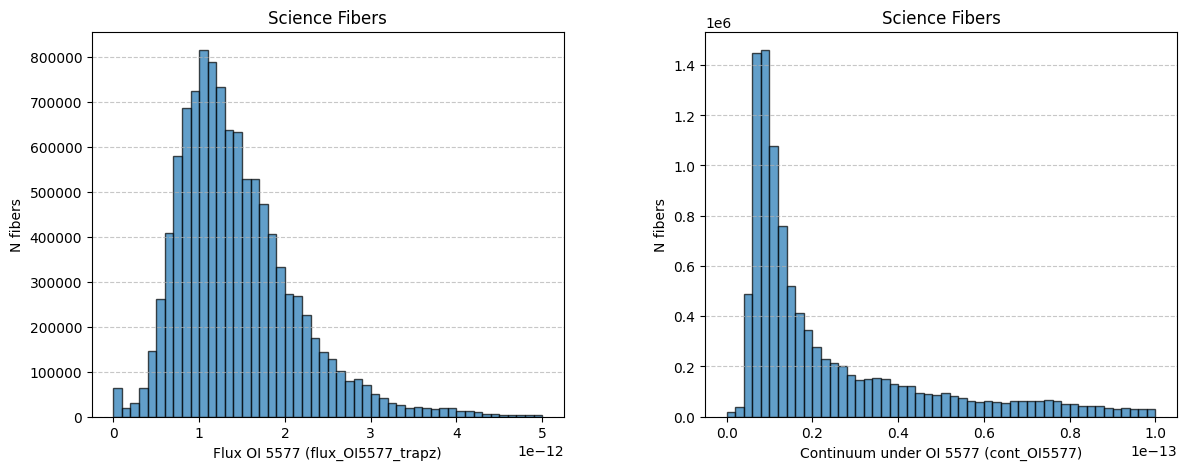

In [43]:
flux_OI = tf[msk_sci]['flux_OI5577_trapz']
cont_OI = tf[msk_sci]['cont_OI5577']

fig = plt.figure(figsize=(14, 5))
gs = GridSpec(1, 2, width_ratios=[1, 1], wspace=0.3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


ax1.hist(flux_OI, bins=50, range=(0, 5e-12), alpha=0.7, edgecolor='black')
# plt.yscale('log')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_title('Science Fibers')
ax1.set_xlabel('Flux OI 5577 (flux_OI5577_trapz)')
ax1.set_ylabel('N fibers')

ax2.hist(cont_OI, bins=50, range=(0, 1e-13), alpha=0.7, edgecolor='black')
# plt.yscale('log')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.set_title('Science Fibers')
ax2.set_xlabel('Continuum under OI 5577 (cont_OI5577)')
ax2.set_ylabel('N fibers')

plt.show()

In [60]:
tf_by_exposure = tf[msk_sci].group_by('exposure')

Check that we have 6126 exposures available in 1.1.0.

In [61]:
print(len(tf_by_exposure.groups.keys))

6126


Aggregate by `exposure` to check OI flux variations across the entire exposure.

In [64]:
exposures_mean = tf_by_exposure['exposure', 'flux_OI5577_trapz', 'cont_OI5577'].groups.aggregate(np.mean)
exposures_mean.rename_column('flux_OI5577_trapz', 'mean_flux_OI5577')
exposures_mean.rename_column('cont_OI5577', 'mean_cont_OI5577')

exposures_std = tf_by_exposure['exposure', 'flux_OI5577_trapz', 'cont_OI5577'].groups.aggregate(np.std)
exposures_std.rename_column('flux_OI5577_trapz', 'std_flux_OI5577')
exposures_std.rename_column('cont_OI5577', 'std_cont_OI5577')

exposures = join(exposures_mean, exposures_std, keys='exposure')

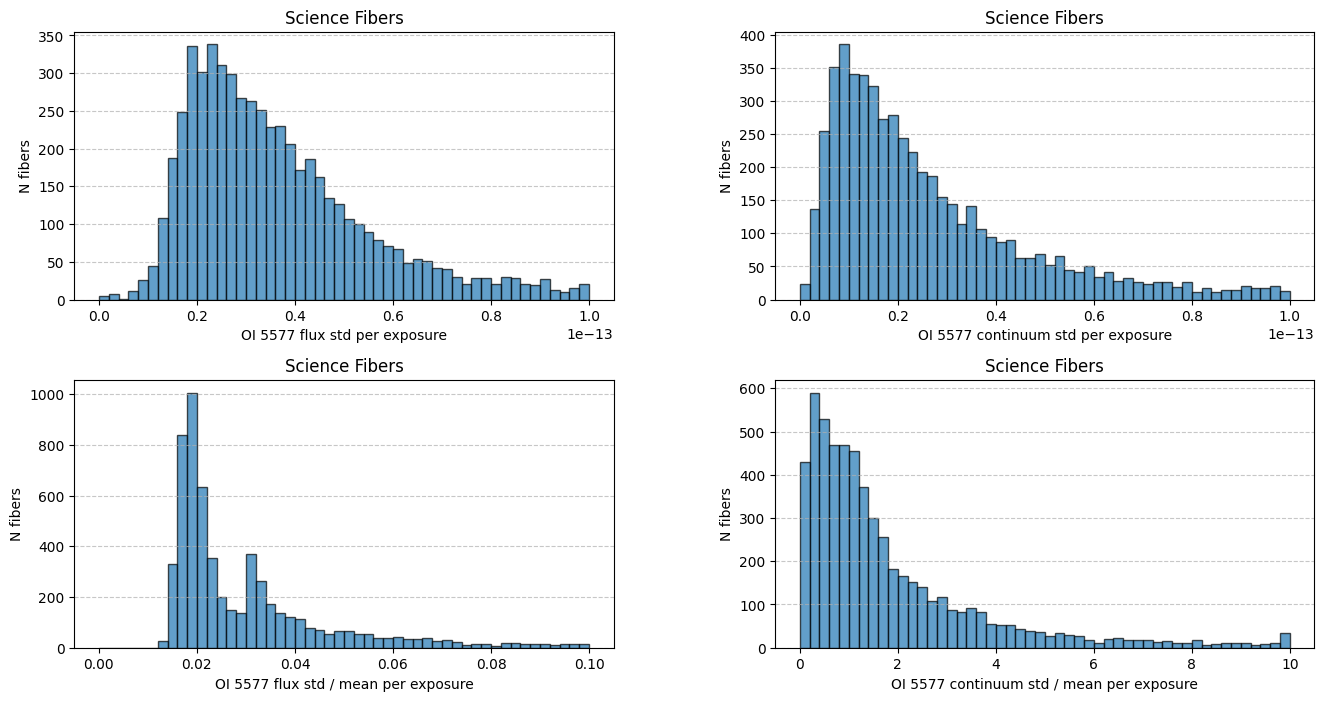

In [78]:
flux_OI = tf[msk_sci]['flux_OI5577_trapz']
cont_OI = tf[msk_sci]['cont_OI5577']

fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 2, width_ratios=[1, 1], wspace=0.3, hspace=0.3)
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1])
ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs[1, 1])

ax11.hist(exposures['std_flux_OI5577'], bins=50, range=(0, 1e-13), alpha=0.7, edgecolor='black')
ax11.grid(axis='y', linestyle='--', alpha=0.7)
ax11.set_title('Science Fibers')
ax11.set_xlabel('OI 5577 flux std per exposure')
ax11.set_ylabel('N fibers')

ax12.hist(exposures['std_cont_OI5577'], bins=50, range=(0, 1e-13), alpha=0.7, edgecolor='black')
ax12.grid(axis='y', linestyle='--', alpha=0.7)
ax12.set_title('Science Fibers')
ax12.set_xlabel('OI 5577 continuum std per exposure')
ax12.set_ylabel('N fibers')

ax21.hist(exposures['std_flux_OI5577'] / exposures['mean_flux_OI5577'], bins=50, range=(0, 0.1), alpha=0.7, edgecolor='black')
ax21.grid(axis='y', linestyle='--', alpha=0.7)
ax21.set_title('Science Fibers')
ax21.set_xlabel('OI 5577 flux std / mean per exposure')
ax21.set_ylabel('N fibers')

ax22.hist(exposures['std_cont_OI5577'] / exposures['mean_cont_OI5577'], bins=50, range=(0, 10), alpha=0.7, edgecolor='black')
ax22.grid(axis='y', linestyle='--', alpha=0.7)
ax22.set_title('Science Fibers')
ax22.set_xlabel('OI 5577 continuum std / mean per exposure')
ax22.set_ylabel('N fibers')

plt.show()